In [2]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')  

# <font color="#E56717">IOBS & IBA Project Briefing</font>

## <font color="#E56717">Thursday 29 September 2016</font>

# <font color="#E56717">PBT compared to traditional RT</font>

* <span style="font-size:1.5em;">SEER-Medicare; number of PBT patients in the data</span>
* <span style="font-size:1.5em;">Patient Matching results and "End-digit Preference" (exclude tumor size measurement in matching)</span>
* <span style="font-size:1.5em;">Kaplan-Meier Survival Curves; PBT has statistically significant better survival curve</span>
* <span style="font-size:1.5em;">Map: evidence of demand and willingness to travel</span>
* <span style="font-size:1.5em;">No observable difference in likelihood of developing a secondary malignancy</span>
* <span style="font-size:1.5em;">More information about the Truven data </span>
* <span style="font-size:1.5em;">Discussion of other comparisons: (Emergency Room Visits, particular complications, total costs, etc)</span>

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import Series, DataFrame
import pytz
from pytz import common_timezones, all_timezones
import matplotlib
matplotlib.style.use('ggplot')
%matplotlib inline
from datetime import datetime
import scipy as sp
import statsmodels.api as sm
import statsmodels.formula.api as smf
matplotlib.style.use('fivethirtyeight')
matplotlib.style.use('seaborn-talk')
import os
import collections

preDouble = "\\\\iobsdc01\\SharedDocs\\SEER_MEDICARE\\SEER_MEDICARE_STAGING"
new = os.chdir(preDouble)
#print(preDouble)

In [4]:
df = pd.read_pickle('dfpedsfFirsts.pickle')

# <font color='#E56717'>SEER-Medicare Data Files</font>


* <span style="font-size:1.5em;">Patient Entitlement and Diagnosis Summary File (PEDSF)</span>
* <span style="font-size:1.5em;">Medicare Provider Analysis and Review (MEDPAR)</span>
*  <span style="font-size:1.5em;">Carrier Claims (old file name Physician/Supplier Part B (NCH))</span>
*  <span style="font-size:1.5em;">Outpatient Claims</span>
*  <span style="font-size:1.5em;">Home Health Agency (HAA)</span>
*  <span style="font-size:1.5em;">Hospice</span>
*  <span style="font-size:1.5em;">Durable Medical Equipment (DME)</span>
*  <span style="font-size:1.5em;">Medicare Part D Data</span>

In [6]:
papaya = '#E56717'

# <font color='#E56717'>First order of business is to identify all the patients in the SEER-Medicare data who have received PBT</font>



<span style="font-size:1.5em;">The relevant HCPCS are:</span>

* <span style="font-size:1.5em;">77520 - Proton trmt simple w/o comp</span>
* <span style="font-size:1.5em;">77522 - Proton trmt simple w/comp</span>
* <span style="font-size:1.5em;">77523 - Proton trmt intermediate</span>
* <span style="font-size:1.5em;">77525 - Proton treatment complex</span>

<span style="font-size:1.5em;">as well as the HCPCS code S8030 (Scleral application of tantalum ring(s) for localization of lesions for proton beam therapy)</span>

# <font color='#E56717'>Use the Outpatient Claims and Carrier Claims files</font>


* <span style="font-size:1.5em;">218 Outpatient Claims files</span>
* <span style="font-size:1.5em;">207 Carrier Claims files</span>


<span style="font-size:1.5em;">Loop through all of these files and capture the set of all the</span> <span style="font-size:1.5em;font-family:Consolas,Monaco;">patient_id</span> <span style="font-size:1.5em;">s corresponding to the PBT HCPCS codes</span>

<span style="font-size:1.8em;">**Result: 1584 unique PBT patients appear in the claims files for claims in years 2006-2013**</span>


In [7]:
mask = (df['srvm1'] != 9999)
dfall = df[mask]

In [8]:
geomask = (dfall['elevation_1'] != dfall['FIPScombo_1']) 

dfall = dfall[geomask].copy()

In [9]:
dfall['elevation_1'].replace('99999',np.nan,inplace=True)
dfall['elevation_2'].replace('99999',np.nan,inplace=True)
dfall['elevation_3'].replace('99999',np.nan,inplace=True)

dfall['lat_1'].replace('99999',np.nan,inplace=True)
dfall['lat_2'].replace('99999',np.nan,inplace=True)
dfall['lat_3'].replace('99999',np.nan,inplace=True)

dfall['lng_1'].replace('99999',np.nan,inplace=True)
dfall['lng_2'].replace('99999',np.nan,inplace=True)
dfall['lng_3'].replace('99999',np.nan,inplace=True)

dfall['elevation_1'] = dfall['elevation_1'].astype('float')
dfall['elevation_2'] = dfall['elevation_2'].astype('float')
dfall['elevation_3'] = dfall['elevation_3'].astype('float')

dfall['lat_1'] = dfall['lat_1'].astype('float')
dfall['lat_2'] = dfall['lat_2'].astype('float')
dfall['lat_3'] = dfall['lat_3'].astype('float')

dfall['lng_1'] = dfall['lng_1'].astype('float')
dfall['lng_2'] = dfall['lng_2'].astype('float')
dfall['lng_3'] = dfall['lng_3'].astype('float')

In [10]:
import pickle
fileObject = open('patient_ids_from_outsaf.pickle', 'rb')
b = pickle.load(fileObject)
fileObject.close()
treatmentindices_outsaf = list(set.union(*b))

In [11]:
import pickle
fileObject = open('patient_ids_from_nch.pickle', 'rb')
b = pickle.load(fileObject)
fileObject.close()
treatmentindices_nch = list(set.union(*b))

In [12]:
bigtreatmentindices = list(set(treatmentindices_nch+treatmentindices_outsaf))

dfall.set_index('patient_id', inplace=True,drop=False)

allindices = dfall.index

In [13]:
bigtreatmentset = set(bigtreatmentindices)
allset = set(allindices)


alltreatmentindices = list(allset.intersection(bigtreatmentset))

treatmentindices = alltreatmentindices
#len(treatmentindices)

# <font color='#E56717'>Now use the pedsf files to perform patient matching, using the <span style="font-family:Consolas;">patient_id</span> s found above</font>

<span style="font-size:1.5em;">List of pedsf files (contains SEER cases for diagnosis year dates 2006-2011):</span>

* <span style="font-size:1.0em;">pedsf.nasopharynx.cancer.txt</span>
* <span style="font-size:1.0em;">pedsf.salivarygland.cancer.txt</span>
* <span style="font-size:1.0em;">pedsf.oropharynx.cancer.txt</span>
* <span style="font-size:1.0em;">pedsf.esophagus.cancer.txt</span>
* <span style="font-size:1.0em;">pedsf.brain.cancer.txt</span>
* <span style="font-size:1.0em;">pedsf.eyeandorbit.cancer.txt</span>
* <span style="font-size:1.0em;">pedsf.softtissue.cancer.txt</span>
* <span style="font-size:1.0em;">pedsf.prostate.cancer.file01.txt</span>
* <span style="font-size:1.0em;">pedsf.prostate.cancer.file02.txt</span>
* <span style="font-size:1.0em;">pedsf.prostate.cancer.file03.txt</span>
* <span style="font-size:1.0em;">pedsf.lung.cancer.file01.txt</span>
* <span style="font-size:1.0em;">pedsf.lung.cancer.file02.txt</span>
* <span style="font-size:1.0em;">pedsf.breast.cancer.file01.txt</span>
* <span style="font-size:1.0em;">pedsf.breast.cancer.file02.txt</span>


# <font color='E56717'>The pedsf files contain one single row for each patient, and contain the information for up to 10 different primary tumors</font>

<span style="font-size:1.5em;">So the prostate cancer files contain all patients with a cancer diagnosis where the primary site is the prostate for ANY of the potentially 10 different primary tumors associated with that patient and where that prostate site tumor has a diagnosis date anywhere between 2006 and 2011.</span>

 

In [14]:
import pedsfhelp

df2 = pedsfhelp.make_clean_dataframe('pedsf.salivarygland.cancer.txt')
#print(df2.shape)

<span style="font-size:1.5em;">For example, in the  file pedsf.salivarygland.cancer.txt, the cancer sites for the first tumor listed for each patient has the following distribution:</span>

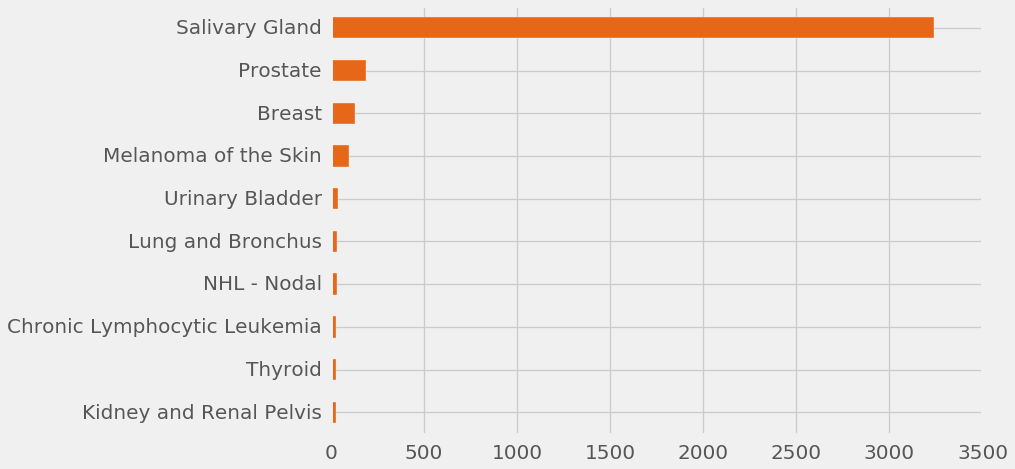

In [15]:
df2.siterwho1.value_counts()[:10][::-1].plot(kind='barh',
                                            color='#E56717');
plt.tick_params(labelsize=20)

## <font color="E56717">Only keep those patients whose first tumor is at the site indicated in the corresponding file</font>

<span style="font-size:1.5em;">This way we avoid the complications other than the cancer under consideration that may be contributing factors to the outcomes we are analyzing.</span>

<span style="font-size:1.5em;">Also restrict the analysis to those patients who received some form of radiation treatment for this first diagnosis</span>


<span style="font-size:1.5em;">These restrictions bring down the number of patients under consideration in the concatenated pedsf file: 719821 total patients down to 277130 non PBT patients available for matching </span>

<span style="font-size:1.5em;">Also brings down the number of PBT patients under consideration: 1605 down to 1200</span>

In [16]:
dfall.patient_id.isin(treatmentindices).sum()

1605

In [17]:
dfall.shape

(719821, 496)

In [18]:
non_rad1 = dfall.rad1.str.contains('None',case=False,na=False)
refused_rad1 = dfall.rad1.str.contains('refused',case=False,na=False)
unknown_rad1 = dfall.rad1.str.contains('unknown',case=False,na=False)

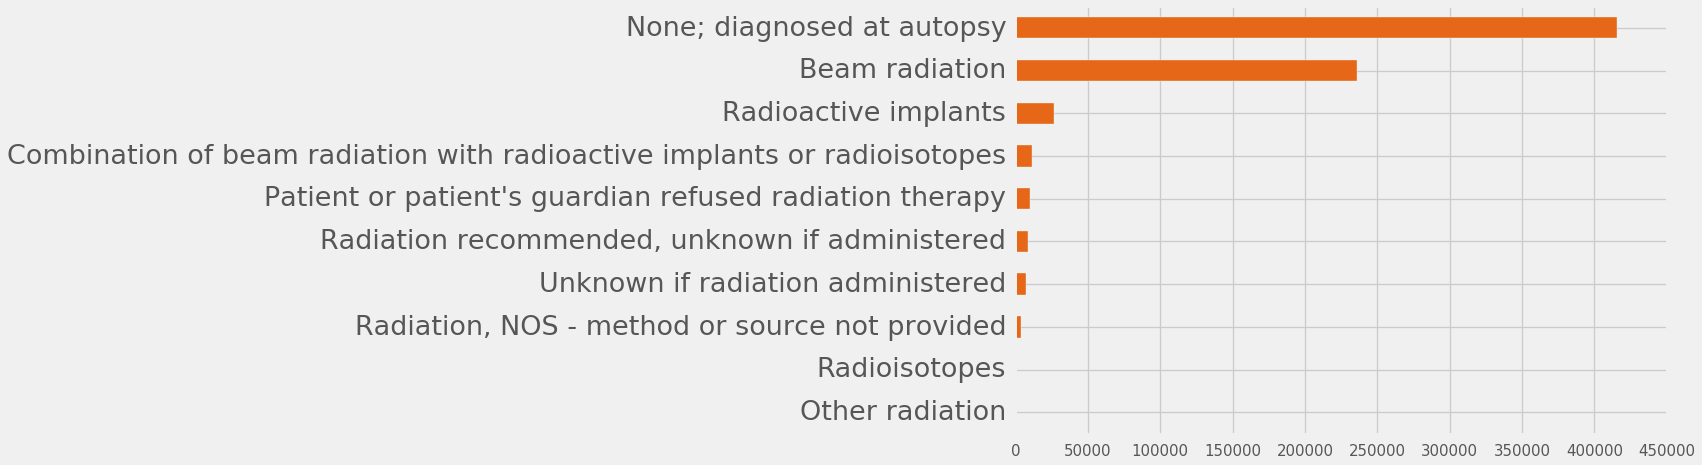

In [19]:
import mpld3
mpld3.disable_notebook()
ax = dfall.rad1.value_counts()[::-1].plot(kind='barh',color='#E56717')
ax.yaxis.set_tick_params(labelsize=27)
ax.xaxis.set_tick_params(labelsize=15)
#plt.tick_params(labelsize=27) # remove the None, refused and unknown group

In [20]:

one = ~non_rad1 & ~refused_rad1 & ~unknown_rad1

had_rad = one

dfsmall = dfall[had_rad].copy()


In [21]:
dfsmall.shape

(278330, 496)

In [22]:
smalltreatmentindices = dfsmall[dfsmall.patient_id.isin(treatmentindices)].index
smallcontrolindices = dfsmall[~dfsmall.patient_id.isin(treatmentindices)].index


In [23]:
smallcontrolindices.shape

(277130,)

In [24]:
smalltreatmentindices.shape

(1200,)

In [25]:
dfalltreatment = dfsmall.loc[smalltreatmentindices].copy()
dfallcontrol = dfsmall.loc[smallcontrolindices].copy()


# <font color='#E56717'>So we are going to match patients who have received PBT (1200 of them) with one of the 277130 patients who have received some other form of radiation</font>

<span style="font-size:1.5em;">We first need to decide on which features (or columns) of the data to use to define the feature space; and then do some preprocessing of this data ("one-hot-encode" the categorical features)</span>

In [26]:
dfsmall.columns

Index(['casereg', 'patient_id', 'casenumber', 'fivepct', 'medicaredateofdeath',
       'birthm', 'birthyr', 'm_sex', 'race', 'state',
       ...
       'icdot09_1_description', 'icdot09_2_description',
       'icdot09_3_description', 'icdot09_4_description',
       'icdot09_5_description', 'icdot09_6_description',
       'icdot09_7_description', 'icdot09_8_description',
       'icdot09_9_description', 'icdot09_10_description'],
      dtype='object', length=496)

In [27]:
cstum1mask =  (dfsmall['cstum1'] != "Unknown; size not stated; not stated in patient record") & \
(dfsmall['cstum1'] != "Microscopic focus or foci only; no size of focus is given") & \
(dfsmall['cstum1'] != "989 millimeters or larger") & \
(dfsmall['cstum1'] != "Not applicable") & \
(dfsmall['cstum1'] != "Unknown age") & \
(dfsmall['cstum1'] != "Described as less than 1 cm") & \
(dfsmall['cstum1'] != "Described as less than 2 cm") & \
(dfsmall['cstum1'] != "Described as less than 3 cm") & \
(dfsmall['cstum1'] != 'Indicates no mass or no tumor found; for example, when a tumor of a stated primary site is not found, but the tumor has metastasized') & \
(dfsmall['cstum1'] != "Described as less than 4 cm") & \
(dfsmall['cstum1'] != "Described as less than 5 cm") & \
(dfsmall['cstum1'] != "Not applicable") & \
(dfsmall['cstum1'] != 'Not applicable') & \
(dfsmall['cstum1'] != 996) & \
(dfsmall['cstum1'] != 997) & \
(dfsmall['cstum1'] != 998) & \
(dfsmall['srvm1'] != 9999)

# <font color="#E56717">We will not include the variable **cstum1** (the tumor size in mm) for the following reasons:</font>

* <span style="font-size:1.5em;">Egregious measurement error, plots to follow for lung and prostate</span>
* <span style="font-size:1.5em;">Over half of the patients have missing values, or text values instead of numbers</span>
    * "Unknown; size not stated; not stated in patient record"
    * "Microscopic focus or foci only; no size of focus is given"
    * "989 millimeters or larger"
    * "Not applicable"
    * "Described as less than 1 cm"
    * "Described as less than 2 cm"
    * "Described as less than 3 cm"
    * 'Indicates no mass or no tumor found; for example, when a tumor of a stated primary site is not found, but the tumor has metastasized'
    * "Described as less than 4 cm"
    * "Described as less than 5 cm"


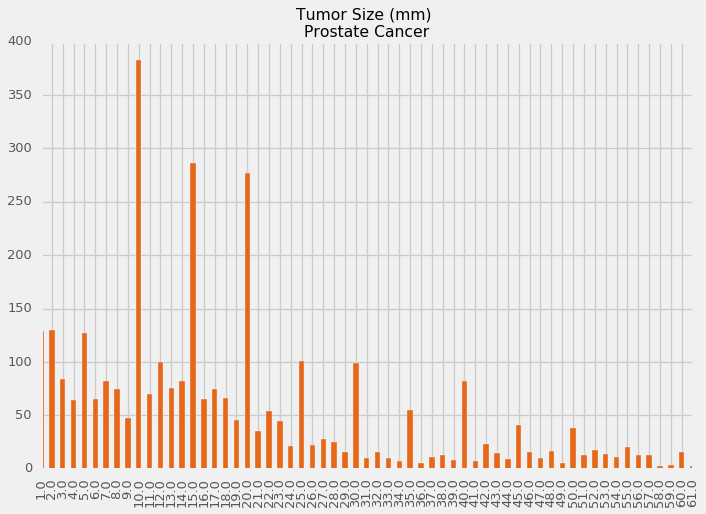

In [28]:
dfsmall[cstum1mask & dfsmall.siterwho1.str.contains("prostate",case=False,na=False)].cstum1.value_counts().sort_index().plot(kind='bar',
            title='Tumor Size (mm) \nProstate Cancer',color='#E56717');
plt.xlim(0,60);

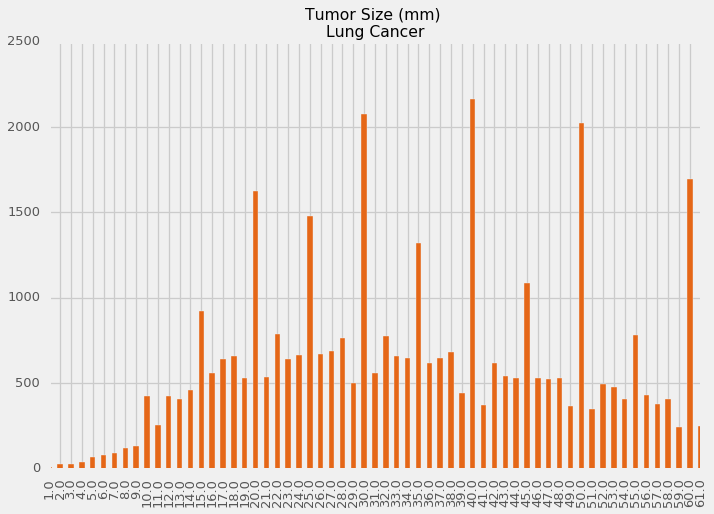

In [29]:
fig1 = plt.figure()
ax = dfsmall[cstum1mask & dfsmall.siterwho1.str.contains("lung",case=False,na=False)].cstum1.value_counts().sort_index().plot(kind='bar',
            title='Tumor Size (mm) \nLung Cancer',color='#E56717');
plt.xlim(0,60);

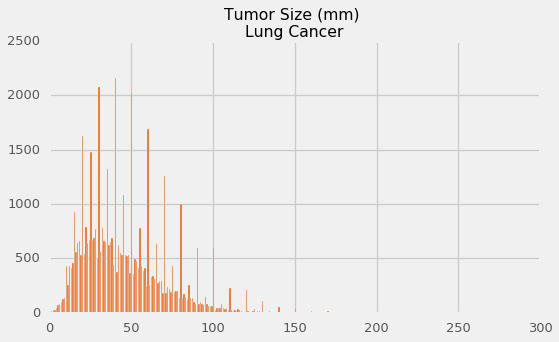

In [33]:
import mpld3
fig, ax = plt.subplots(figsize=(8,5))
huh = dfsmall[cstum1mask & dfsmall.siterwho1.str.contains("lung",case=False,na=False)].cstum1.value_counts().sort_index()
xvalues = huh.index
yvalues = huh.values

rects = ax.bar(xvalues,yvalues,color='#E56717')
plt.xlim(0,300)
plt.title('Tumor Size (mm) \nLung Cancer')
plt.tight_layout()
plt.show()


In [34]:

mpld3.disable_notebook()
mpld3.display(fig)

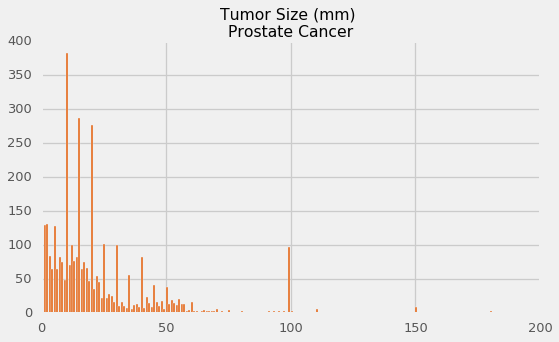

In [35]:
figp, ax = plt.subplots(figsize=(8,5))
huh = dfsmall[cstum1mask & dfsmall.siterwho1.str.contains("prostate",case=False,na=False)].cstum1.value_counts().sort_index()
xvalues = huh.index
yvalues = huh.values

rects = ax.bar(xvalues,yvalues,color='#E56717')
plt.xlim(0,200)
plt.title("Tumor Size (mm) \nProstate Cancer")
plt.tight_layout()
plt.show()


In [36]:
mpld3.display(figp)

# <font color="#E56717">This phenomena is so common (including in medicine) it has a name</font>

## End-digit preference

<span style="font-size:1.5em;">"In converting analog to digital data, observers may record some terminal digits with an unusual frequency, for example rounding off may be to the nearest whole number, even number, multiple of 5 or 10, or when time units like a week are involved, 7, 14, etc."</span>  

- Encyclopedia of Epidemiologic Methods, by By Mitchell H. Gail, Jacques Benichou



In [37]:
catcols = ['m_sex','marst1','srace','nhiade','grade1',
           'site1',
          'histrec1',
           'modx1','stat_rec']


goodcols = ['m_sex','marst1', 'srace','nhiade',
           'grade1','site1',
           'lat1','histrec1',
           'modx1','stat_rec','birthyr',
           'agedx1',
           'yrdx1','elevation_1',
           'lng_1']



In [38]:
dfpop = pd.concat([dfallcontrol, dfalltreatment])

In [39]:
resgoodcontrol = pd.concat([pd.get_dummies(dfallcontrol[col],prefix=col) for col in catcols], axis=1)

resgoodtreatment = pd.concat([pd.get_dummies(dfalltreatment[col],prefix=col) for col in catcols], axis=1)

resgoodpop = pd.concat([pd.get_dummies(dfpop[col],prefix=col) for col in catcols], axis=1)

In [40]:
print(goodcols)

['m_sex', 'marst1', 'srace', 'nhiade', 'grade1', 'site1', 'lat1', 'histrec1', 'modx1', 'stat_rec', 'birthyr', 'agedx1', 'yrdx1', 'elevation_1', 'lng_1']


In [41]:
resgoodcontrol['birthyr'] = dfallcontrol['birthyr']
resgoodcontrol['agedx1'] = dfallcontrol['agedx1']

resgoodcontrol['yrdx1'] = dfallcontrol['yrdx1']

resgoodcontrol['lat_1'] = dfallcontrol['lat_1']

resgoodcontrol['lng_1'] = dfallcontrol['lng_1']

resgoodcontrol['srvm1'] = dfallcontrol['srvm1']

resgoodcontrol['elevation_1'] = dfallcontrol['elevation_1']

In [42]:
resgoodtreatment['birthyr'] = dfalltreatment['birthyr']
resgoodtreatment['agedx1'] = dfalltreatment['agedx1']

resgoodtreatment['yrdx1'] = dfalltreatment['yrdx1']



resgoodtreatment['lat_1'] = dfalltreatment['lat_1']

resgoodtreatment['lng_1'] = dfalltreatment['lng_1']

resgoodtreatment['srvm1'] = dfalltreatment['srvm1']

resgoodtreatment['elevation_1'] = dfalltreatment['elevation_1']

In [43]:
resgoodpop['birthyr'] = dfpop['birthyr']
resgoodpop['agedx1'] = dfpop['agedx1']

resgoodpop['yrdx1'] = dfpop['yrdx1']




resgoodpop['lat_1'] = dfpop['lat_1']

resgoodpop['lng_1'] = dfpop['lng_1']

resgoodpop['srvm1'] = dfpop['srvm1']

resgoodpop['elevation_1'] = dfpop['elevation_1']

# <font color="#E56717">After performing the matching bewteen the control and treatment groups, we can see how the Kaplan-Meier curves differ</font>

<span style="font-size:1.5em;">Below is how it looks before matching patients in the control and treatment groups together in pairs</span>

In [44]:
from lifelines import KaplanMeierFitter

kmfpop = KaplanMeierFitter()
kmfcontrol = KaplanMeierFitter()
kmftreatment = KaplanMeierFitter()

Tcontrol = resgoodpop.loc[smallcontrolindices]["srvm1"]
Econtrol = resgoodpop.loc[smallcontrolindices]["stat_rec_Dead"]

Ttreatment = resgoodpop.loc[smalltreatmentindices]["srvm1"]
Etreatment = resgoodpop.loc[smalltreatmentindices]["stat_rec_Dead"]

Tpop = resgoodpop["srvm1"]
Epop = resgoodpop["stat_rec_Dead"]

kmfpop.fit(Tpop, event_observed=Epop,label='All Radiation group');
kmfcontrol.fit(Tcontrol, event_observed=Econtrol,label='Non PT group (control group)')
kmftreatment.fit(Ttreatment, event_observed=Etreatment, label='PT group (treatment group)')

<lifelines.KaplanMeierFitter: fitted with 1200 observations, 1051 censored>

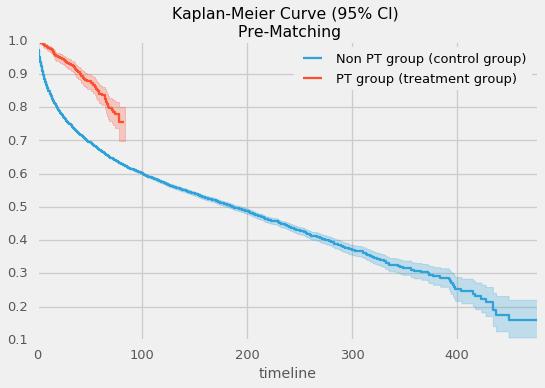

In [45]:
mpld3.enable_notebook()
ax = kmfcontrol.plot(figsize=(8,5))
kmftreatment.plot(ax=ax)
plt.title("Kaplan-Meier Curve (95% CI) \n Pre-Matching");

In [46]:
mpld3.disable_notebook()


# <font color="#E56717">Clearly, there is a difference between these survival curves</font>

<span style="font-size:1.5em;">But one can argue that we are not really comparing apples to apples when we calculate these two survival curves. To answer this objection, we need to perform patient matching, so that we are really comparing apples to apples and that any marked difference in the survival curves can be confidently attributed to the difference in treatment modalites.</span>

In [47]:
resgoodpop['birthyr'] = resgoodpop['birthyr'].astype('int')
resgoodpop['agedx1'] = resgoodpop['agedx1'].astype('float')



resgoodpop['lat_1'] = resgoodpop['lat_1'].astype('float')



resgoodpop['lng_1'] = resgoodpop['lng_1'].astype('float')
resgoodpop['elevation_1'] = resgoodpop['elevation_1'].astype('float')

resgoodpop['srvm1'] = resgoodpop['srvm1'].astype('float')


newcolumns = list(resgoodpop.columns)

newcolumns.remove('srvm1')
newcolumns.remove('stat_rec_Alive')
newcolumns.remove('stat_rec_Dead')
newcolumns.remove('m_sex_Male')

resgreatpop = resgoodpop[newcolumns].copy()

In [48]:
resgreatpop['patient_id'] = resgreatpop.index
leaguefilter = (resgreatpop['patient_id'].loc[smalltreatmentindices])
resgreatpop['League'] = resgreatpop['patient_id'].isin(smalltreatmentindices).astype('int')
del resgreatpop['patient_id']
dftree = resgreatpop.copy()

y = dftree['League'].copy()
del dftree['League']

In [49]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize, StandardScaler
from sklearn.multiclass import OneVsRestClassifier

import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plot
#import psycopg2
import random
from sklearn import ensemble
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.cross_validation import StratifiedShuffleSplit
import pylab as plot
from pandas import DataFrame, Series
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import KFold
from sklearn.feature_extraction import DictVectorizer
from sklearn import feature_extraction
from sklearn.cross_validation import train_test_split
from sklearn.feature_extraction import DictVectorizer as DV
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model.logistic import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.grid_search import ParameterGrid
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
#from sklearn.neural_network import MultilayerPerceptronClassifier
from sklearn.neural_network import BernoulliRBM
from sklearn.svm import SVC
import pylab as pl
from sklearn.decomposition import RandomizedPCA
from itertools import cycle
from sklearn.cross_validation import ShuffleSplit
from scipy.stats import sem
from pprint import pprint
from math import sqrt, fabs, exp
import matplotlib.pyplot as plot
from sklearn.cross_validation import train_test_split
from sklearn import ensemble
from sklearn.metrics import roc_auc_score, roc_curve
import numpy
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from pandas.tools.plotting import lag_plot

In [50]:
print(list(dftree.columns))

['m_sex_Female', 'marst1_Divorced', 'marst1_Married (including common law)', 'marst1_Separated', 'marst1_Single (never married)', 'marst1_Unknown', 'marst1_Unmarried or domesntic partner (same sex or opposite sex or unregistered)', 'marst1_Widowed', 'srace_American Indian, Aleutian, Alaska Native or Eskimo (includes all indigenous populations of the Western hemisphere)', 'srace_Asian Indian', 'srace_Asian Indian or Pakistani, NOS', 'srace_Black', 'srace_Chamorran', 'srace_Chinese', 'srace_Fiji Islander', 'srace_Filipino', 'srace_Guamanian, NOS', 'srace_Hawaiian', 'srace_Hmong', 'srace_Japanese', 'srace_Kampuchean (including Khmer and Cambodian)', 'srace_Korean', 'srace_Laotian', 'srace_Melanesian, NOS', 'srace_Micronesian, NOS', 'srace_New Guinean', 'srace_Other', 'srace_Other Asian, including Asian, NOS and Oriental NOS', 'srace_Pacific Islander, NOS', 'srace_Pakistani', 'srace_Polynesian, NOS', 'srace_Samoan', 'srace_Tahitian', 'srace_Thai', 'srace_Tongan', 'srace_Unknown', 'srace_Vi

<span style="font-size:1.5em;">This brute force method of finding similar patients in a high-dimensional space is possible thanks to a data structure called a KDTree. In order to construct the KDTree, we first need to transform the numeric data so that all of the different features contribute equally to the euclidean distance between patients/records. For example, agedx1 is on the order of 60 or so, while birthyr is around 1960. Without standardization, birthyr would contribute much more to the distance between patients than agedx1. The result of standardization (or z-score normalization) is that features will be rescaled so that they will have</span>

$
\mu = 0$ and $\sigma=1$

where $\mu$ is the mean and $\sigma$ is the standard deviation from the mean; z-scores are then calculated as follows:

$
z_{i} = \frac{x_{i} - \mu}{\sigma}
$



In [51]:
dftree.shape

(278330, 191)

In [52]:
xTrain = dftree.values
xTrain = StandardScaler().fit_transform(xTrain)
from sklearn.neighbors import KDTree
print(xTrain)

[[-0.97715169 -0.33244105  0.82425607 ...,  0.80092569  1.33097646
  -0.58351592]
 [-0.97715169 -0.33244105  0.82425607 ...,  0.80092569  1.33097646
  -0.58351592]
 [-0.97715169 -0.33244105  0.82425607 ...,  0.78631771  1.30326753
  -0.29739877]
 ..., 
 [ 1.02338256 -0.33244105  0.82425607 ..., -0.51424012 -0.80200908
   1.40418896]
 [ 1.02338256 -0.33244105  0.82425607 ..., -0.72200522 -0.84977582
  -0.01095906]
 [ 1.02338256 -0.33244105  0.82425607 ..., -0.51424012 -0.80200908
   1.40418896]]


In [53]:
from sklearn.neighbors import KDTree
kdt = KDTree(xTrain, leaf_size=30)

# <font color="#E56717">Here is a video explaining the construction of a KDTree</font>

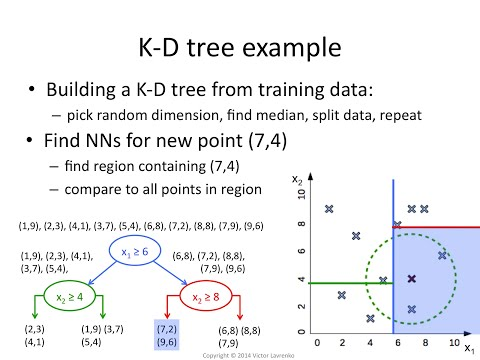

In [54]:
from IPython.display import YouTubeVideo
YouTubeVideo('Y4ZgLlDfKDg')

In [55]:

dftreeleague = dftree.copy()
dftreeleague['League'] = y

def get_league(x):
    return dftreeleague['League'].loc[x]

dist4, ind4 = kdt.query(xTrain, k=4, return_distance=True)

# <font color="#E56717">Finding the distance to all of the 4 nearest neighbors only took about 90 minutes</font>

In [56]:
dftreeleague['nearest'] = pd.Series(ind4[:,0],index=dftreeleague.index)
dftreeleague['neighbor_1'] = pd.Series(ind4[:,1],index=dftreeleague.index)
dftreeleague['neighbor_2'] = pd.Series(ind4[:,2],index=dftreeleague.index)
dftreeleague['neighbor_3'] = pd.Series(ind4[:,3],index=dftreeleague.index)
dftreeleague['distance_1'] = pd.Series(dist4[:,1],index=dftreeleague.index)
dftreeleague['distance_2'] = pd.Series(dist4[:,2],index=dftreeleague.index)
dftreeleague['distance_3'] = pd.Series(dist4[:,3],index=dftreeleague.index)

dfmap = {v: dftreeleague.index[v] for v in range(dftreeleague.shape[0])}


In [57]:
def get_pubcsnum(x,transformationdict = dfmap):
    return dfmap[x]


dftreeleague['neighbor_1'] = dftreeleague['neighbor_1'].apply(get_pubcsnum)
dftreeleague['neighbor_2'] = dftreeleague['neighbor_2'].apply(get_pubcsnum)
dftreeleague['neighbor_3'] = dftreeleague['neighbor_3'].apply(get_pubcsnum)

def get_league(x):
    return dftreeleague['League'].loc[x]

dftreeleague['neighbor_1_League'] = dftreeleague['neighbor_1'].apply(get_league)
dftreeleague['neighbor_2_League'] = dftreeleague['neighbor_2'].apply(get_league)
dftreeleague['neighbor_3_League'] = dftreeleague['neighbor_3'].apply(get_league)

neighbor_1_match = (dftreeleague['neighbor_1_League'] == 0)

dist1filter = (dftreeleague['distance_1'] <= 2)
dist2filter = (dftreeleague['distance_2'] <= 2)
dist3filter = (dftreeleague['distance_3'] <= 2)

one = dftreeleague[['neighbor_1','distance_1',
                  'neighbor_1_League'
]][(dftreeleague['neighbor_1_League'] != dftreeleague['League']) & (neighbor_1_match) & (dist1filter)].copy()


neighbor_2_match = (dftreeleague['neighbor_2_League'] == 0)

two = dftreeleague[['neighbor_2','distance_2',
                  'neighbor_2_League'
]][(dftreeleague['neighbor_2_League'] != dftreeleague['League']) & (neighbor_2_match) & (dist2filter)].copy()


neighbor_3_match = (dftreeleague['neighbor_3_League'] == 0)

three = dftreeleague[['neighbor_3','distance_3',
                  'neighbor_3_League'
]][(dftreeleague['neighbor_3_League'] != dftreeleague['League']) & (neighbor_3_match) & (dist3filter) ].copy()

one.head(10)

,neighbor_1,distance_1,neighbor_1_League
patient_id,,,
8865019342,8882020381,0.549251,0
2281022515,4260019093,1.199885,0
4315229060,8792067479,1.358663,0
4349078094,8748022560,0.858701,0
4473112043,4408106073,0.460446,0
8804056423,8825006483,0.452837,0
8807062300,8869056364,1.884280,0
8809061300,8727032479,1.914789,0
8851092441,8841081424,1.755724,0


In [58]:
onedict = one['neighbor_1'].to_dict()
twodict = two['neighbor_2'].to_dict()
threedict = three['neighbor_3'].to_dict()

from collections import defaultdict

dd = defaultdict(list)

for d in (onedict, twodict, threedict):
    for key, value in d.items():
        dd[key].append(value)
        
        

goodtreatmentteams = list(dd.keys())

goodcontrolteams = list(dd.values())
matches = list(set([item for sublist in goodcontrolteams for item in sublist]))

controlindices = matches
treatmentindices = goodtreatmentteams
print(len(treatmentindices))
print(len(controlindices))

1086
2780


# <font color="E56717">Need to do a one-to-one matching (where each member of the treatment group is matched to one and only one member of the control group, and where that matched control corresponds to only one member in the treatment group</font>

In [59]:
d_one_to_one = {k: dd[k][0] for k in dd}
d_t_c = {}

for key, value in d_one_to_one.items():
    if value not in d_t_c.values():
        d_t_c[key] = value
        
treatmentindices = list(d_t_c.keys())
controlindices = list(d_t_c.values())    

In [60]:
treatmentindices = list(d_t_c.keys())
controlindices = list(d_t_c.values())

print(len(controlindices), len(treatmentindices))

1055 1055


<span style="font-size:2.0em; color='#E56717';">So we have 1055 treatment patients matched very closely to 1055 control patients</span>

In [61]:
from lifelines import KaplanMeierFitter

#kmfpop = KaplanMeierFitter()
kmfcontrolpost = KaplanMeierFitter()
kmftreatmentpost = KaplanMeierFitter()

Tcontrol = resgoodpop.loc[controlindices]["srvm1"]
Econtrol = resgoodpop.loc[controlindices]["stat_rec_Dead"]

Ttreatment = resgoodpop.loc[treatmentindices]["srvm1"]
Etreatment = resgoodpop.loc[treatmentindices]["stat_rec_Dead"]

Tpop = resgoodpop["srvm1"]
Epop = resgoodpop["stat_rec_Dead"]

#kmfpop.fit(Tpop, event_observed=Epop,label='All Nasopharynx');
kmfcontrolpost.fit(Tcontrol, event_observed=Econtrol,label='No PT Group (control group; post-matching)')
kmftreatmentpost.fit(Ttreatment, event_observed=Etreatment, label='PT Group (treatment group; post-matching)')
#ax = kmfpop.plot()
###ax = kmfcontrol.plot()
###kmftreatment.plot(ax=ax)
###plt.title("Nasopharynx Kaplan-Meier Curve (95% CI) \n Post-Matching");

<lifelines.KaplanMeierFitter: fitted with 1055 observations, 950 censored>

# <font color="#E56717">Now here is the Kaplan-Meier plot for the post-matching treatment and control groups</font>

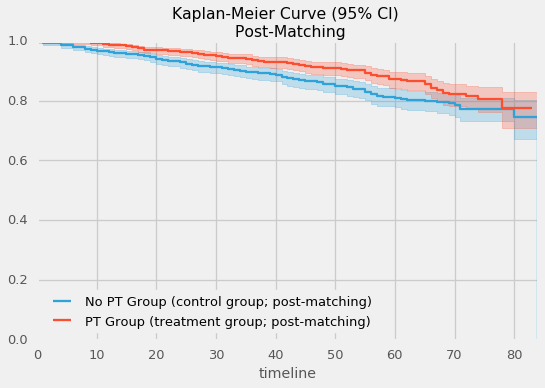

In [62]:
mpld3.enable_notebook()
ax = kmfcontrolpost.plot(figsize=(8,5))
kmftreatmentpost.plot(ax=ax)
plt.title("Kaplan-Meier Curve (95% CI) \n Post-Matching");

# <font color="#E56717">We can perform a rigorous test to see if the two survival curves truly have different DGPs (data generation processes)</font>

In [63]:

from lifelines.statistics import logrank_test
results = logrank_test(Ttreatment, Tcontrol, Etreatment, Econtrol)
results.print_summary()

Results
   alpha: 0.95
   test: logrank
   df: 1
   null distribution: chi squared
   t 0: -1

   __ p-value ___|__ test statistic __|____ test result ____|__ is significant __
         0.00175 |              9.795 |      Reject Null    |        True       


In [64]:
import pickle
fileObject = open('control_indicies.pickle','wb')
pickle.dump(controlindices, fileObject)
fileObject.close()

In [65]:
import pickle
fileObject = open('treatment_indicies.pickle','wb')
pickle.dump(treatmentindices, fileObject)
fileObject.close()

In [66]:
df = df.set_index('patient_id',drop=False)

# <font color="#E56717">Investigate the results of the matching</font>

In [67]:

df['grade1'][df['patient_id'].isin(treatmentindices)].value_counts()

Grade III; grade iii, grade 3; poorly differentiated; differentiated                                               523
Grade II; grade ii; grade 2; moderately differentiated; moderately differentiated; intermediate differentiation    436
cell type not determined, not stated or not applicable                                                              82
Grade I; grade i, grade 1; well differentiated; differentiated, NOS                                                  7
Grade IV; grade iv; grade 4; undifferentaited; anaplastic                                                            7
Name: grade1, dtype: int64

In [68]:
df['grade1'][df['patient_id'].isin(controlindices)].value_counts()

Grade III; grade iii, grade 3; poorly differentiated; differentiated                                               523
Grade II; grade ii; grade 2; moderately differentiated; moderately differentiated; intermediate differentiation    436
cell type not determined, not stated or not applicable                                                              82
Grade I; grade i, grade 1; well differentiated; differentiated, NOS                                                  7
Grade IV; grade iv; grade 4; undifferentaited; anaplastic                                                            7
Name: grade1, dtype: int64

In [69]:

df['srace'][df['patient_id'].isin(treatmentindices)].value_counts()

White                                                                                                                 962
Black                                                                                                                  47
Other Asian, including Asian, NOS and Oriental NOS                                                                     12
Chinese                                                                                                                 9
Filipino                                                                                                                8
Korean                                                                                                                  6
Japanese                                                                                                                6
Vietnamese                                                                                                              2
American Indian, Aleutia

In [70]:
df['srace'][df['patient_id'].isin(controlindices)].value_counts()


White                                                                                                                 962
Black                                                                                                                  47
Other Asian, including Asian, NOS and Oriental NOS                                                                     12
Chinese                                                                                                                 9
Filipino                                                                                                                8
Korean                                                                                                                  6
Japanese                                                                                                                6
Vietnamese                                                                                                              2
American Indian, Aleutia

In [71]:
df['site1'][df['patient_id'].isin(treatmentindices)].value_counts()

Prostate gland                    935
Choroid                            48
Upper lobe, lung                   32
Lower lobe, lung                    7
Cerebral meninges                   4
Upper-outer quadrant of breast      4
Frontal lobe                        4
Lower third of esophagus            3
Temporal lobe                       2
Overlapping lesion of breast        2
Lung, NOS                           2
Main bronchus                       2
Ciliary body                        2
Lower-inner quadrant of breast      2
Parietal lobe                       1
Middle third of esophagus           1
Cervical esophagus                  1
Parotid gland                       1
Acoustic nerve                      1
Retina                              1
Name: site1, dtype: int64

In [72]:
df['site1'][df['patient_id'].isin(controlindices)].value_counts()

Prostate gland                    935
Choroid                            48
Upper lobe, lung                   32
Lower lobe, lung                    7
Cerebral meninges                   4
Upper-outer quadrant of breast      4
Frontal lobe                        4
Lower third of esophagus            3
Temporal lobe                       2
Overlapping lesion of breast        2
Lung, NOS                           2
Main bronchus                       2
Ciliary body                        2
Lower-inner quadrant of breast      2
Parietal lobe                       1
Middle third of esophagus           1
Cervical esophagus                  1
Parotid gland                       1
Acoustic nerve                      1
Retina                              1
Name: site1, dtype: int64

In [73]:
goodcols_eval = ['m_sex','marst1','srace','nhiade','grade1','site1','lat1','lat_1','lng_1',
                 'elevation_1','histrec1',
            'modx1','birthyr','agedx1','yrdx1']

# <font color="#E56717">Look at some matched pairs</font>

In [74]:
df[goodcols_eval].loc[[controlindices[0],treatmentindices[0]]]

,m_sex,marst1,srace,nhiade,grade1,site1,lat1,lat_1,lng_1,elevation_1,histrec1,modx1,birthyr,agedx1,yrdx1
patient_id,,,,,,,,,,,,,,,
8832098450,Male,Married (including common law),White,Non-Spanish-Hispanic-Latino,"Grade III; grade iii, grade 3; poorly differen...",Prostate gland,Not a paired site,38.3105,-121.902,54.3486,8140-8398: adenomas and adenocarcinomas,May,1935,73,2009
8810018305,Male,Married (including common law),White,Non-Spanish-Hispanic-Latino,"Grade III; grade iii, grade 3; poorly differen...",Prostate gland,Not a paired site,38.3105,-121.902,54.3486,8140-8398: adenomas and adenocarcinomas,May,1934,74,2009


In [75]:
df[goodcols_eval].loc[[controlindices[1],treatmentindices[1]]]


,m_sex,marst1,srace,nhiade,grade1,site1,lat1,lat_1,lng_1,elevation_1,histrec1,modx1,birthyr,agedx1,yrdx1
patient_id,,,,,,,,,,,,,,,
8894032329,Male,Married (including common law),Filipino,Non-Spanish-Hispanic-Latino,Grade II; grade ii; grade 2; moderately differ...,Prostate gland,Not a paired site,34.0522,-118.244,284.596,8140-8398: adenomas and adenocarcinomas,Jul,1937,71,2009
8856041492,Male,Married (including common law),Filipino,Non-Spanish-Hispanic-Latino,Grade II; grade ii; grade 2; moderately differ...,Prostate gland,Not a paired site,32.7157,-117.161,49.9128,8140-8398: adenomas and adenocarcinomas,Jul,1942,68,2010


In [76]:
df[goodcols_eval].loc[[controlindices[2],treatmentindices[2]]]

,m_sex,marst1,srace,nhiade,grade1,site1,lat1,lat_1,lng_1,elevation_1,histrec1,modx1,birthyr,agedx1,yrdx1
patient_id,,,,,,,,,,,,,,,
8876023391,Male,Married (including common law),White,Non-Spanish-Hispanic-Latino,"Grade III; grade iii, grade 3; poorly differen...",Prostate gland,Not a paired site,32.7157,-117.161,49.9128,8140-8398: adenomas and adenocarcinomas,Mar,1934,72,2007
8854088302,Male,Married (including common law),White,Non-Spanish-Hispanic-Latino,"Grade III; grade iii, grade 3; poorly differen...",Prostate gland,Not a paired site,33.7175,-117.831,76.3626,8140-8398: adenomas and adenocarcinomas,Mar,1935,72,2007


In [77]:
df[goodcols_eval].loc[[controlindices[3],treatmentindices[3]]]

,m_sex,marst1,srace,nhiade,grade1,site1,lat1,lat_1,lng_1,elevation_1,histrec1,modx1,birthyr,agedx1,yrdx1
patient_id,,,,,,,,,,,,,,,
8885047362,Male,Married (including common law),White,"Spanish/Hispanic/Latino, NOS","Grade III; grade iii, grade 3; poorly differen...",Prostate gland,Not a paired site,36.1342,-118.86,929.537,8140-8398: adenomas and adenocarcinomas,Mar,1925,82,2008
8827013461,Male,Married (including common law),White,"Spanish/Hispanic/Latino, NOS","Grade III; grade iii, grade 3; poorly differen...",Prostate gland,Not a paired site,34.9592,-116.419,2586.31,8140-8398: adenomas and adenocarcinomas,Mar,1927,82,2010


In [78]:
choroidindex = list(df[goodcols_eval][df.site1.str.contains('choroid',case=False,na=False)].index)

treatmentchoroid = [a for a in set(choroidindex).intersection(set(treatmentindices))]


#####################################################################################################

lungindex = list(df[goodcols_eval][df.site1.str.contains('lung',case=False,na=False)].index)

treatmentlung = [a for a in set(lungindex).intersection(set(treatmentindices))]

############################################################################################################


cerebralindex = list(df[goodcols_eval][df.site1.str.contains('cerebral',case=False,na=False)].index)

treatmentcerebral = [a for a in set(cerebralindex).intersection(set(treatmentindices))]

##############################################################################################################

esophagusindex = list(df[goodcols_eval][df.site1.str.contains('esophagus',case=False,na=False)].index)

treatmentesophagus = [a for a in set(esophagusindex).intersection(set(treatmentindices))]

#####################################################################################################################


breastindex = list(df[goodcols_eval][df.site1.str.contains('breast',case=False,na=False)].index)

treatmentbreast = [a for a in set(breastindex).intersection(set(treatmentindices))]

In [79]:
df[goodcols_eval].loc[[d_t_c[treatmentchoroid[0]],treatmentchoroid[0]]]

,m_sex,marst1,srace,nhiade,grade1,site1,lat1,lat_1,lng_1,elevation_1,histrec1,modx1,birthyr,agedx1,yrdx1
patient_id,,,,,,,,,,,,,,,
8888053370,Female,Married (including common law),White,Non-Spanish-Hispanic-Latino,"cell type not determined, not stated or not ap...",Choroid,Right: origin of primary,37.4337,-122.401,616.83,8720-8799: nevi and melanomas,May,1930,75,2006
8888051360,Female,Married (including common law),White,Non-Spanish-Hispanic-Latino,"cell type not determined, not stated or not ap...",Choroid,Right: origin of primary,37.3337,-121.891,91.6477,8720-8799: nevi and melanomas,May,1926,79,2006


In [80]:
df[goodcols_eval].loc[[d_t_c[treatmentchoroid[2]],treatmentchoroid[2]]]

,m_sex,marst1,srace,nhiade,grade1,site1,lat1,lat_1,lng_1,elevation_1,histrec1,modx1,birthyr,agedx1,yrdx1
patient_id,,,,,,,,,,,,,,,
2038167088,Female,Married (including common law),White,Non-Spanish-Hispanic-Latino,"cell type not determined, not stated or not ap...",Choroid,Right: origin of primary,42.2791,-83.3362,644.84,8720-8799: nevi and melanomas,Jun,1942,65,2007
0268475080,Female,Married (including common law),White,Non-Spanish-Hispanic-Latino,"cell type not determined, not stated or not ap...",Choroid,Right: origin of primary,41.7924,-72.8043,784.126,8720-8799: nevi and melanomas,Jun,1937,70,2007


In [81]:
df[goodcols_eval].loc[[d_t_c[treatmentlung[0]],treatmentlung[0]]]

,m_sex,marst1,srace,nhiade,grade1,site1,lat1,lat_1,lng_1,elevation_1,histrec1,modx1,birthyr,agedx1,yrdx1
patient_id,,,,,,,,,,,,,,,
0262483060,Female,Divorced,White,Non-Spanish-Hispanic-Latino,"cell type not determined, not stated or not ap...","Upper lobe, lung",Left: origin of primary,41.7924,-72.8043,784.126,8140-8398: adenomas and adenocarcinomas,Jun,1933,75,2008
4295048060,Female,Divorced,White,Non-Spanish-Hispanic-Latino,"cell type not determined, not stated or not ap...","Upper lobe, lung",Left: origin of primary,38.1938,-85.6435,510.116,8140-8398: adenomas and adenocarcinomas,Jun,1928,79,2007


In [82]:
df[goodcols_eval].loc[[d_t_c[treatmentlung[1]],treatmentlung[1]]]

,m_sex,marst1,srace,nhiade,grade1,site1,lat1,lat_1,lng_1,elevation_1,histrec1,modx1,birthyr,agedx1,yrdx1
patient_id,,,,,,,,,,,,,,,
8850051423,Male,Married (including common law),White,Non-Spanish-Hispanic-Latino,"cell type not determined, not stated or not ap...","Upper lobe, lung",Left: origin of primary,32.7157,-117.161,49.9128,8140-8398: adenomas and adenocarcinomas,Jun,1944,66,2010
8888086461,Male,Married (including common law),White,Non-Spanish-Hispanic-Latino,"cell type not determined, not stated or not ap...","Upper lobe, lung",Right: origin of primary,33.9533,-117.396,827.484,8140-8398: adenomas and adenocarcinomas,Jun,1943,66,2010


In [83]:
df[goodcols_eval].loc[[d_t_c[treatmentcerebral[0]],treatmentcerebral[0]]]

,m_sex,marst1,srace,nhiade,grade1,site1,lat1,lat_1,lng_1,elevation_1,histrec1,modx1,birthyr,agedx1,yrdx1
patient_id,,,,,,,,,,,,,,,
4323056044,Female,Widowed,White,Non-Spanish-Hispanic-Latino,"cell type not determined, not stated or not ap...",Cerebral meninges,Right: origin of primary,32.7551,-93.6623,247.575,9530-9539: meningiomas,May,1930,77,2007
8899061320,Female,Widowed,White,Non-Spanish-Hispanic-Latino,"cell type not determined, not stated or not ap...",Cerebral meninges,Left: origin of primary,33.9533,-117.396,827.484,9530-9539: meningiomas,May,1935,70,2006


In [84]:
df[goodcols_eval].loc[[d_t_c[treatmentcerebral[1]],treatmentcerebral[1]]]

,m_sex,marst1,srace,nhiade,grade1,site1,lat1,lat_1,lng_1,elevation_1,histrec1,modx1,birthyr,agedx1,yrdx1
patient_id,,,,,,,,,,,,,,,
8857091381,Female,Married (including common law),Black,Non-Spanish-Hispanic-Latino,"cell type not determined, not stated or not ap...",Cerebral meninges,Left: origin of primary,34.0522,-118.244,284.596,9530-9539: meningiomas,Apr,1960,46,2007
8859072460,Female,Married (including common law),Black,Non-Spanish-Hispanic-Latino,"cell type not determined, not stated or not ap...",Cerebral meninges,Right: origin of primary,33.9533,-117.396,827.484,9530-9539: meningiomas,Apr,1961,48,2009


In [85]:
df[goodcols_eval].loc[[d_t_c[treatmentesophagus[0]],treatmentesophagus[0]]]

,m_sex,marst1,srace,nhiade,grade1,site1,lat1,lat_1,lng_1,elevation_1,histrec1,modx1,birthyr,agedx1,yrdx1
patient_id,,,,,,,,,,,,,,,
4408106073,Male,Married (including common law),White,Non-Spanish-Hispanic-Latino,"Grade III; grade iii, grade 3; poorly differen...",Lower third of esophagus,Not a paired site,39.9653,-74.3118,58.8656,8140-8398: adenomas and adenocarcinomas,Dec,1929,77,2006
4473112043,Male,Married (including common law),White,Non-Spanish-Hispanic-Latino,"Grade III; grade iii, grade 3; poorly differen...",Lower third of esophagus,Not a paired site,39.8592,-75.0144,49.2433,8140-8398: adenomas and adenocarcinomas,Dec,1928,79,2007


In [86]:
df[goodcols_eval].loc[[d_t_c[treatmentesophagus[2]],treatmentesophagus[2]]]

,m_sex,marst1,srace,nhiade,grade1,site1,lat1,lat_1,lng_1,elevation_1,histrec1,modx1,birthyr,agedx1,yrdx1
patient_id,,,,,,,,,,,,,,,
8748022560,Female,Married (including common law),White,Non-Spanish-Hispanic-Latino,Grade II; grade ii; grade 2; moderately differ...,Middle third of esophagus,Not a paired site,33.3717,-84.7316,877.411,8050-8089: squamous cell neplasms,Jul,1941,68,2010
4349078094,Female,Married (including common law),White,Non-Spanish-Hispanic-Latino,Grade II; grade ii; grade 2; moderately differ...,Middle third of esophagus,Not a paired site,32.4272,-92.2237,176.11,8050-8089: squamous cell neplasms,Jul,1939,70,2009


In [87]:
df[goodcols_eval].loc[[d_t_c[treatmentbreast[0]],treatmentbreast[0]]]

,m_sex,marst1,srace,nhiade,grade1,site1,lat1,lat_1,lng_1,elevation_1,histrec1,modx1,birthyr,agedx1,yrdx1
patient_id,,,,,,,,,,,,,,,
8807000441,Female,Married (including common law),White,Non-Spanish-Hispanic-Latino,Grade II; grade ii; grade 2; moderately differ...,Overlapping lesion of breast,Right: origin of primary,33.9533,-117.396,827.484,8500-8549: ductal and lobular neoplasms,Sep,1946,64,2010
8888027441,Female,Married (including common law),White,Non-Spanish-Hispanic-Latino,Grade II; grade ii; grade 2; moderately differ...,Overlapping lesion of breast,Left: origin of primary,33.9533,-117.396,827.484,8500-8549: ductal and lobular neoplasms,Sep,1944,65,2010


In [88]:
df[goodcols_eval].loc[[d_t_c[treatmentbreast[1]],treatmentbreast[1]]]

,m_sex,marst1,srace,nhiade,grade1,site1,lat1,lat_1,lng_1,elevation_1,histrec1,modx1,birthyr,agedx1,yrdx1
patient_id,,,,,,,,,,,,,,,
8785033458,Female,Single (never married),White,Non-Spanish-Hispanic-Latino,"Grade I; grade i, grade 1; well differentiated...",Lower-inner quadrant of breast,Right: origin of primary,31.5282,-83.8897,399.093,8500-8549: ductal and lobular neoplasms,Feb,1942,63,2006
8771011409,Female,Single (never married),White,Non-Spanish-Hispanic-Latino,"Grade I; grade i, grade 1; well differentiated...",Lower-inner quadrant of breast,Right: origin of primary,33.7956,-84.2279,919.933,8500-8549: ductal and lobular neoplasms,Feb,1939,69,2009


In [89]:
dgt = df[goodcols_eval].loc[treatmentindices].copy()
dgc = df[goodcols_eval].loc[controlindices].copy()
from mpl_toolkits.basemap import Basemap

In [90]:
centers_dict = {'Davis, CA': [38.5568118,-121.7700491],
               'Loma Linda, CA': [34.0428589,-117.2838294],
               'Boston, MA': [42.3132878,-71.1975851],
               'Seattle, WA': [47.6147624,-122.4763332],
               'Bloomington, IN': [39.1711919,-86.602058],
               'Jacksonville, FL': [30.3446899,-82.0013407],
               'Houston, TX': [29.8168809,-95.6821725],
               'Oklahoma City, OK': [35.4823226,-97.7600756],
               'Warrenvlile, IL': [41.8247102,-88.2168148],
               'Philadelphia, PA': [40.004668,-75.2584614],
               'Hampton, VA': [37.0403431,-76.4311508],
               'Somerset, NJ': [40.5012296,-74.507752],
               'St. Louis, MO': [38.6530166,-90.3838907],
               'Knoxville, TN': [35.9583816,-84.0655115],
               'San Diego, CA': [32.8242389,-117.3760429],
               'Jacksonville, FL': [30.3446899,-82.0013407],
               'New Brunswick, NJ': [40.4882392,-74.4763898],
               'Dallas Fort Worth, TX': [32.7724978,-97.2485344],
               'Phoenix, AZ': [33.6050976,-112.4059302],
               'Rochester, MN': [43.9959015,-92.6216003],
               'Orlando, FL': [28.4810968,-81.5091799],
               'Miami, FL': [25.7823071,-80.3012157]}

In [91]:

center_lats = [l[0] for l in centers_dict.values()]
center_lngs = [l[1] for l in centers_dict.values()]



# <font color="#E56717">It is informative to plot the locations of the treatment and control patients on a map, along with the location of the PBT centers</font>

* <span style="font-size:1.5em;">Knoxville, TN; Warrenville, IL; Philadelphia, PA; Seattle, WA</span>
* <span style="font-size:1.5em;">Loma Linda, CA; San Diego, CA; Oralando, FL; Bloomington, IN (now closed)</span>
* <span style="font-size:1.5em;">Rochester, MN; New Brunswick, NJ; Houston, TX; St. Louis, MO</span>
* <span style="font-size:1.5em;">Miami, FL; Davis, CA; Dallas Fort-Worth, TX; Boston, MA</span>
* <span style="font-size:1.5em;">Somerset, NJ; Oklahoma City, OK; Jacksonville, FL; Phoenix, AZ</span>
* <span style="font-size:1.5em;">Hampton, VA</span>

In [92]:
print(centers_dict.keys())

dict_keys(['San Diego, CA', 'Dallas Fort Worth, TX', 'Somerset, NJ', 'Phoenix, AZ', 'Loma Linda, CA', 'New Brunswick, NJ', 'Boston, MA', 'Bloomington, IN', 'Rochester, MN', 'Seattle, WA', 'Davis, CA', 'Houston, TX', 'St. Louis, MO', 'Miami, FL', 'Orlando, FL', 'Knoxville, TN', 'Warrenvlile, IL', 'Oklahoma City, OK', 'Hampton, VA', 'Philadelphia, PA', 'Jacksonville, FL'])


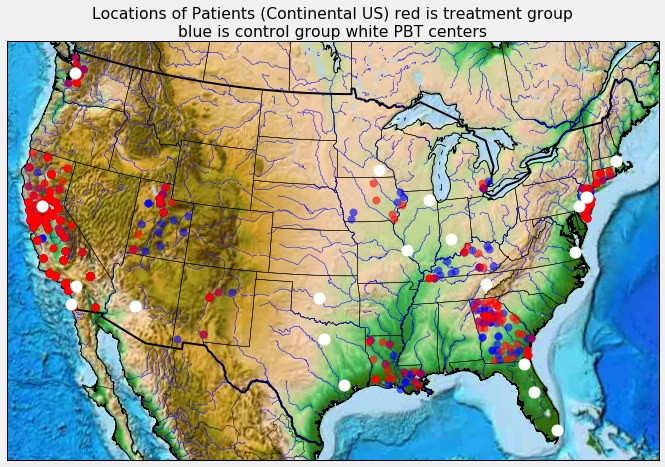

In [93]:
# Lambert Conformal map of USA lower 48 states
mpld3.disable_notebook()
m = Basemap(llcrnrlon=-119, llcrnrlat=22, urcrnrlon=-64,
  urcrnrlat=49, projection='lcc', lat_1=33, lat_2=45,
  lon_0=-95, resolution='h', area_thresh=10000)

m.drawcoastlines()
# draw country boundaries
m.drawcountries(linewidth=2)
# draw states boundaries (America only)
m.drawstates()
#m.bluemarble()
m.etopo()

# fill the background (the oceans)
m.drawmapboundary(fill_color='aqua')
# fill the continental area
# we color the lakes like the oceans
#m.fillcontinents(color='coral',lake_color='aqua')

m.drawrivers(color='#0000ff')

# Define our longitude and latitude points
# We have to use .values because of a wierd bug when passing pandas data
# to basemap.
x,y = m(dgt['lng_1'].values, dgt['lat_1'].values)
xc, yc = m(dgc['lng_1'].values, dgc['lat_1'].values)
xcenters, ycenters = m(center_lngs, center_lats)

# Plot them using round markers of size 6
#m.plot(x, y, 'ro', markersize=8,alpha=.7)
m.plot(xc,yc, 'bo', markersize=8,alpha=.6)
m.plot(x, y, 'ro', markersize=8,alpha=.6)
m.plot(xcenters, ycenters, 'wo', markersize=12)

plt.title("Locations of Patients (Continental US) red is treatment group\nblue is control group white "+\
         "PBT centers")

plt.savefig('map_with_centers.png', format='png')
plt.show()

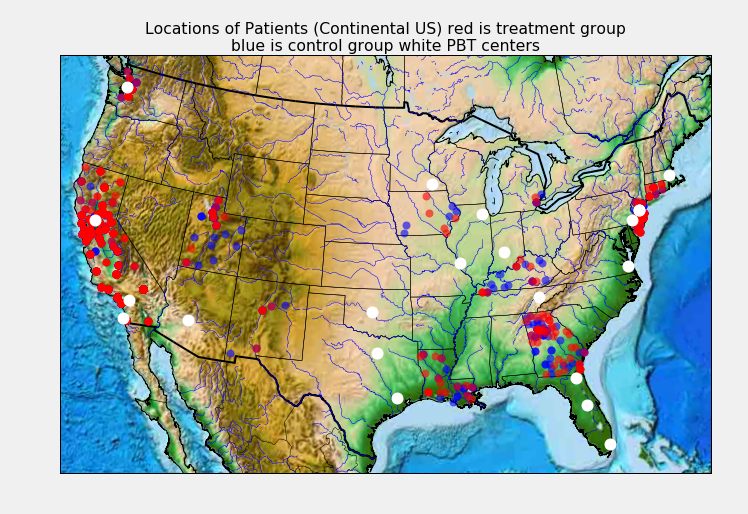

In [94]:
## This is for an `png` image
from IPython.display import Image

fig = Image(filename=('map_with_centers.png'),embed=True)
fig

# <font color="#E56717">Are PBT or conventional RT patients more likely to experience secondary malignancies?</font>

<span style="font-size:1.5em;">We can explore this question in two ways</span>

<span style="font-size:1.5em;">Bayesian A/B testing will be uninformative:</span>

The data indicates almost identical (and very small) chances of a secondary malignancy.

In [95]:
print(df['agedx2'].loc[controlindices].value_counts().sum(), df['agedx2'].loc[controlindices].shape)

58 (1055,)


In [96]:
print(df['agedx2'].loc[treatmentindices].value_counts().sum(), df['agedx2'].loc[treatmentindices].shape)

56 (1055,)


In [97]:
control_agedx2 = df['agedx2'].loc[controlindices].notnull().astype('int')
treatment_agedx2 = df['agedx2'].loc[treatmentindices].notnull().astype('int')
dfagedx2_comp = pd.DataFrame({'control_id': control_agedx2.index,
                             'control_agedx2': control_agedx2.values,
                             'treatment_id': treatment_agedx2.index,
                             'treatment_agedx2': treatment_agedx2.values})

# 1 indicates you have a secondary malignancy

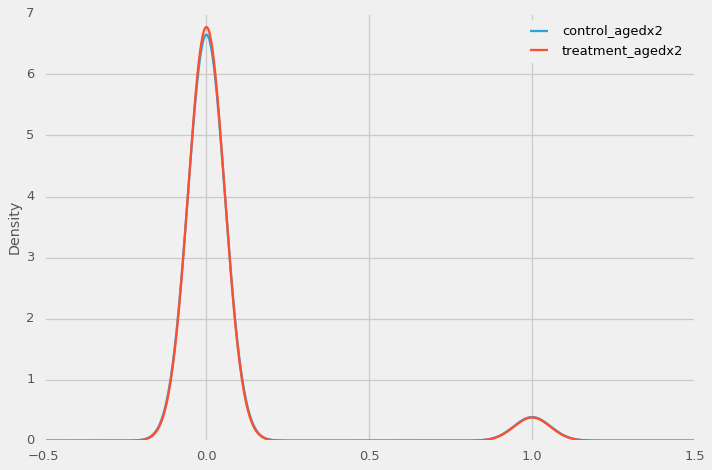

In [98]:
dfagedx2_comp[['control_agedx2','treatment_agedx2']].plot.kde();

In [99]:
from scipy.stats import ttest_ind

t, p = ttest_ind(dfagedx2_comp.control_agedx2.as_matrix(),
               dfagedx2_comp.treatment_agedx2.as_matrix())

print(t,p)

0.192502521304 0.847367135929


In [100]:
from scipy.stats import ranksums, ttest_rel

ttest_rel(dfagedx2_comp.control_agedx2.as_matrix(),
               dfagedx2_comp.treatment_agedx2.as_matrix())

Ttest_relResult(statistic=0.1941685582316994, pvalue=0.84608131667599584)

In [101]:
from scipy.stats import ranksums, wilcoxon

t, p = wilcoxon(dfagedx2_comp.control_agedx2.as_matrix(),
               dfagedx2_comp.treatment_agedx2.as_matrix())

print(t,p)

2782.0 0.845974518219


# <font color="#E56717">Information from Truven</font>

* <span style="font-size:1.5em;">PBT patient counts by site</span>
* <span style="font-size:1.5em;">Accessibility for IBA</span>
    * <span style="font-size:1.5em;">No Problem, only requires a "Data Access Rider" making sure the data is housed in the U.S.</span>
    
```Below are preliminary counts we ran earlier this year for just three years of data (2012-2014) on the number of unique lives for each category so you will have some perspective about volume out of MarketScan (I realize you will likely want data on the most current five years, however).  These numbers fluctuate throughout the year according to any changes in data we receive from our contributors, but this is a snapshot from early 2015.  Also, if a patient is recorded for cancer in more than one of these categories, they would be counted each time (potential double counting).```

In [102]:
truvenindex = ['Lip, Oral Cavity and Pharynx',
              'Breast; Female and Male',
              'Esophagus',
              'Brain and nervous system',
              'Eye and Orbit',
              'Prostate','Soft Tissue','Other Endrocrine System']

dxcodes = [55634, 495153, 17088, 52596, 11755, 349842, 50540, 14241]
dxcodesrad = [14169, 87905, 5695, 16715, 1867, 45546, 10297, 1907]
dxcodespbt = [150, 82, 54, 405, 119, 837, 171, 73]

dftruven = pd.DataFrame({'Count based on Dx Codes': dxcodes,
                        'Counts base don Dx and CPT Codes (Radiation)': dxcodesrad,
                        'Counts based on Dx and CPT Codes (Proton Therapy)': dxcodespbt},
                       index = truvenindex)


In [103]:
dftruven

,Count based on Dx Codes,Counts base don Dx and CPT Codes (Radiation),Counts based on Dx and CPT Codes (Proton Therapy)
"Lip, Oral Cavity and Pharynx",55634,14169,150
Breast; Female and Male,495153,87905,82
Esophagus,17088,5695,54
Brain and nervous system,52596,16715,405
Eye and Orbit,11755,1867,119
Prostate,349842,45546,837
Soft Tissue,50540,10297,171
Other Endrocrine System,14241,1907,73


# <font color="#e56717">Next steps: answer questions using information available in the claims files</font>

* <span style="font-size:1.5em;">Emergency Room Visits</span>
* <span style="font-size:1.5em;">Likelihood of potentially avoidable complications</span>
* <span style="font-size:1.5em;">Cost of Care comparisons</span>